In [32]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Sun May  1 16:47:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    27W /  70W |   4422MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers,models
import pandas as pd
import os
import cv2

## Part 1: Data Preprocessing

### Load Data

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
# 設定資料路徑
# training data path 
trcloudy='/content/drive/MyDrive/weather_iamge/train/cloudy/'
trrain='/content/drive/MyDrive/weather_iamge/train/rain/'
trshine='/content/drive/MyDrive/weather_iamge/train/shine/'
trsunrise='/content/drive/MyDrive/weather_iamge/train/sunrise/'
# testing data path
testpath='/content/drive/MyDrive/weather_iamge/test/'

In [36]:
# 顯示資料筆數
print('train cloudy length: ',len(os.listdir(trcloudy)))
print('train rain length: ',len(os.listdir(trrain)))
print('train shine length: ',len(os.listdir(trshine)))
print('train sunrise length: ',len(os.listdir(trsunrise)))
print('test data length: ',len(os.listdir(testpath)))

train cloudy length:  280
train rain length:  199
train shine length:  232
train sunrise length:  337
test data length:  75


### convert image data to numpy

In [37]:
# convert the train data to numpy
tr_label=list()
tr_data=np.empty(shape=(1048,300,300,3)) #1048 photoes
x=0

# read image as numpy array
for i in range(len(os.listdir(trcloudy))):
  f=os.listdir(trcloudy)[i]
  img=cv2.imread(trcloudy+f)
  img=cv2.resize(img,(300,300))
  img=img[:,:,::-1]/255
  tr_data[x]=img
  tr_label.append(0)
  x+=1
for i in range(len(os.listdir(trrain))):
  f=os.listdir(trrain)[i]
  img=cv2.imread(trrain+f)
  img=cv2.resize(img,(300,300))
  img=img[:,:,::-1]/255
  tr_data[x]=img
  tr_label.append(1)
  x+=1
for i in range(len(os.listdir(trshine))):
  f=os.listdir(trshine)[i]
  img=cv2.imread(trshine+f)
  img=cv2.resize(img,(300,300))
  img=img[:,:,::-1]/255
  tr_data[x]=img
  tr_label.append(2)
  x+=1
for i in range(len(os.listdir(trsunrise))):
  f=os.listdir(trsunrise)[i]
  img=cv2.imread(trsunrise+f)
  img=cv2.resize(img,(300,300))
  img=img[:,:,::-1]/255
  tr_data[x]=img
  tr_label.append(3)
  x+=1

tr_label=np.array(tr_label)

In [38]:
# convert the test data to numpy
te_filename=list()
te_data=np.empty(shape=(75,300,300,3))
for i in range(len(os.listdir(testpath))):
  f=os.listdir(testpath)[i]
  te_filename.append(f)
  img=cv2.imread(testpath+f)
  img=cv2.resize(img,(300,300))
  img=img[:,:,::-1]/255
  te_data[i]=img

In [39]:
# show data size
print('train data size:',tr_data.shape)
print('train label size:',len(tr_label))
print('test data size:',te_data.shape)

train data size: (1048, 300, 300, 3)
train label size: 1048
test data size: (75, 300, 300, 3)


### shuffle

In [40]:
# one-hot label
from tensorflow.keras.utils import to_categorical
tr_label=to_categorical(tr_label)
# 打亂資料順序
from sklearn.utils import shuffle
tr_data,tr_label=shuffle(tr_data,tr_label,random_state=0)

### train_validation data split

In [41]:
# train_validation data split
#val_data數量固定262個
train_data=tr_data[0:786]
val_data=tr_data[786:]
train_label=tr_label[0:786]
val_label=tr_label[786:]
print('train data size: ',train_data.shape)
print('validation data size: ',val_data.shape)
print('train label size: ',train_label.shape)
print('validation label size: ',val_label.shape)

train data size:  (786, 300, 300, 3)
validation data size:  (262, 300, 300, 3)
train label size:  (786, 4)
validation label size:  (262, 4)


## Part 2: Build a simple CNN

In [42]:
import warnings
warnings.filterwarnings('ignore')

import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Add, Input, BatchNormalization, Activation
from keras.layers import  Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten
from keras.optimizers import adam_v2
from keras import callbacks
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.callbacks import ModelCheckpoint


# define model
model = Sequential() # name the network

#BLOCK 1
model.add(Conv2D(filters = 32, kernel_size=(3,3), padding='same', input_shape =(300, 300, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(filters=32, kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

#BLOCK 2
model.add(Conv2D(filters=64, kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(filters=64, kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#BLOCK 3
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#BLOCK 4
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))

#Classifier
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(units=4,activation='softmax'))

# show the model structure
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 300, 300, 32)      896       
                                                                 
 batch_normalization_16 (Bat  (None, 300, 300, 32)     128       
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 300, 300, 32)      0         
                                                                 
 conv2d_17 (Conv2D)          (None, 298, 298, 32)      9248      
                                                                 
 batch_normalization_17 (Bat  (None, 298, 298, 32)     128       
 chNormalization)                                                
                                                                 
 activation_17 (Activation)  (None, 298, 298, 32)     

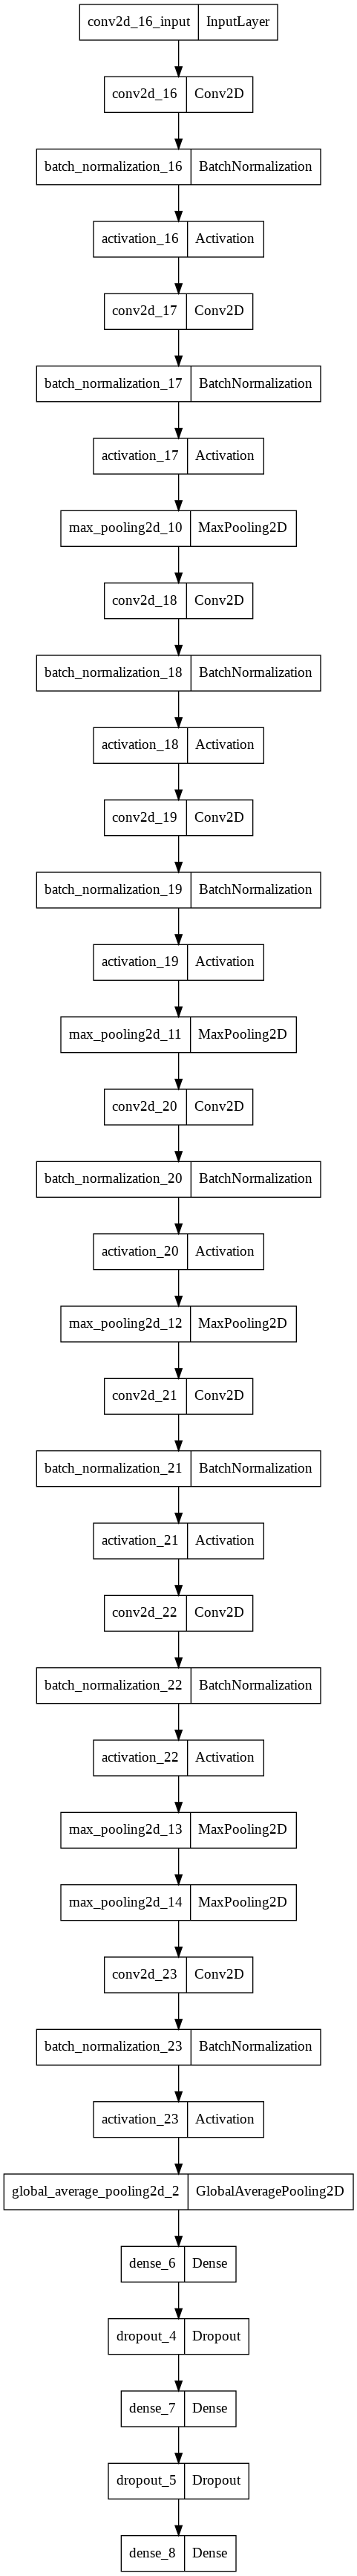

In [43]:
#Saving the model structure to visualize
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png')

In [44]:
# Define the optimizer
opt = adam_v2.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)

#Compile the model
model.compile(optimizer=opt,loss="categorical_crossentropy",metrics=["accuracy"])

In [90]:
# Data Augmentation
'''
datagen = ImageDataGenerator(
        featurewise_center=False,  # 以每一張feature map為單位將平均值設為0
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # 以每一張feature map為單位將數值除以其標準差(上述兩步驟就是我們常見的Standardization)
        samplewise_std_normalization=False,  #  將输入的每個樣本除以其自身的標準差。
        zca_whitening=False,  # dimesion reduction
        rotation_range=0.1,  # 隨機旋轉圖片
        zoom_range = 0.1, #  隨機縮放範圍
        width_shift_range=0.1,  #  水平平移，相對總寬度的比例
        height_shift_range=0.1,  # 垂直平移，相對總高度的比例
        horizontal_flip=False,  # 一半影象水平翻轉
        vertical_flip=False)  # 一半影象垂直翻轉
        '''
datagen = ImageDataGenerator(
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    rotation_range = 10,
    shear_range = 0.1,
    width_shift_range=0.3,  #  水平平移，相對總寬度的比例
    height_shift_range=0.1,  # 垂直平移，相對總高度的比例
    horizontal_flip=True,  # 一半影象水平翻轉
    data_format='channels_last',
    validation_split=0.2)

datagen.fit(train_data)

In [91]:
# save the best weights
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/weather_iamge/cp", verbose=1, save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    )

In [92]:
history = model.fit(train_data, train_label,batch_size=10 ,epochs=200,
                  shuffle=True,
                  validation_split=0.2,
                  validation_data = (val_data, val_label),
                  verbose=1,
                  callbacks=[checkpointer])

Epoch 1/200
63/63 [==============================] - ETA: 0s - loss: 0.0622 - accuracy: 0.9936
Epoch 1: val_accuracy improved from -inf to 0.96835, saving model to /content/drive/MyDrive/weather_iamge/cp
INFO:tensorflow:Assets written to: /content/drive/MyDrive/weather_iamge/cp/assets
63/63 [==============================] - 10s 158ms/step - loss: 0.0622 - accuracy: 0.9936 - val_loss: 0.1746 - val_accuracy: 0.9684
Epoch 2/200
63/63 [==============================] - ETA: 0s - loss: 0.1410 - accuracy: 0.9729
Epoch 2: val_accuracy did not improve from 0.96835
63/63 [==============================] - 6s 98ms/step - loss: 0.1410 - accuracy: 0.9729 - val_loss: 0.2640 - val_accuracy: 0.8987
Epoch 3/200
63/63 [==============================] - ETA: 0s - loss: 0.1005 - accuracy: 0.9650
Epoch 3: val_accuracy improved from 0.96835 to 0.98101, saving model to /content/drive/MyDrive/weather_iamge/cp
INFO:tensorflow:Assets written to: /content/drive/MyDrive/weather_iamge/cp/assets
63/63 [==========

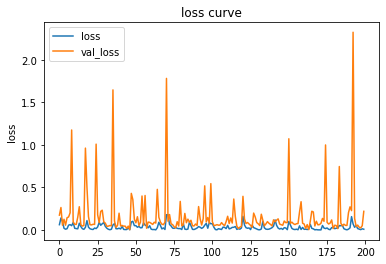

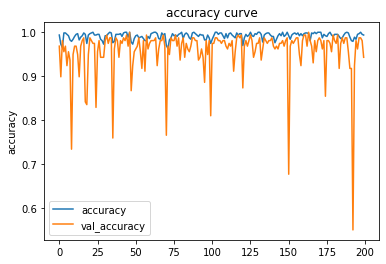

In [93]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('loss curve')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.title('accuracy curve')
plt.ylabel('accuracy')
plt.legend()
plt.show()

### Plot the confusion matrix

In [95]:
from sklearn.metrics import confusion_matrix
pre=model.predict(val_data)
pre=np.argmax(pre,axis=1)

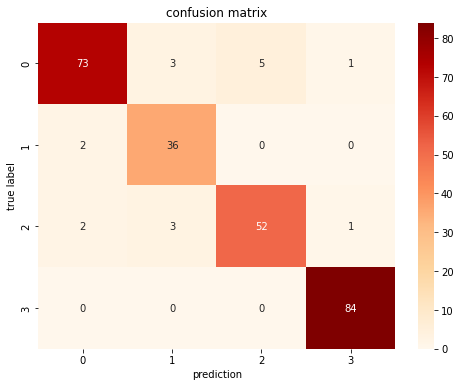

In [96]:
import seaborn as sn
cm=confusion_matrix(pre,np.argmax(val_label,axis=1))
fit=plt.figure(figsize=(8,6))
plt.title('confusion matrix')
sn.heatmap(cm,annot=True,cmap='OrRd',fmt='g')
plt.xlabel('prediction')
plt.ylabel('true label')
plt.show()

In [97]:
for i in range(len(cm)):
    print("Class:",str(i))
    print("Number of Wrong Prediction:", str(sum(cm[i])-cm[i][i]), "out of 1000")
    print("Percentage of True Prediction: {:.2f}%".format(cm[i][i] / 10))
    print("***********************************************************")

Class: 0
Number of Wrong Prediction: 9 out of 1000
Percentage of True Prediction: 7.30%
***********************************************************
Class: 1
Number of Wrong Prediction: 2 out of 1000
Percentage of True Prediction: 3.60%
***********************************************************
Class: 2
Number of Wrong Prediction: 6 out of 1000
Percentage of True Prediction: 5.20%
***********************************************************
Class: 3
Number of Wrong Prediction: 0 out of 1000
Percentage of True Prediction: 8.40%
***********************************************************


# Output the csv file

In [98]:
import pandas as pd

In [99]:
prediction=model.predict(te_data)
prediction=np.argmax(prediction,axis=1)
prediction

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 3, 2, 2, 1, 1, 1, 3, 1, 2, 2,
       2, 1, 2, 3, 1, 1, 0, 2, 1, 2, 2, 2, 0, 0, 1, 1, 2, 2, 0, 2, 3, 2,
       3, 1, 3, 3, 1, 0, 3, 3, 3, 3, 3, 0, 3, 0, 2, 1, 3, 3, 3, 3, 3, 3,
       3, 1, 0, 0, 0, 1, 2, 3, 2])

In [100]:
test_label=pd.DataFrame()
test_label['image_id']=te_filename
test_label['labels']=prediction
test_label=test_label.sort_values(by='image_id')
test_label.to_csv('/content/drive/MyDrive/weather_iamge/predict_label.csv',index=False) #結果轉csv檔